# Predicting Credit Card Default

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
%matplotlib inline

### Back with the credit card default dataset

In [2]:
# Loading the dataset
DATA_DIR = '../data'
FILE_NAME = 'credit_card_default.csv'
data_path = os.path.join(DATA_DIR, FILE_NAME)
ccd = pd.read_csv(data_path, index_col="ID")
ccd.rename(columns=lambda x: x.lower(), inplace=True)
ccd.rename(columns={'default payment next month':'default'}, inplace=True)

# getting the groups of features
bill_amt_features = ['bill_amt'+ str(i) for i in range(1,7)]
pay_amt_features = ['pay_amt'+ str(i) for i in range(1,7)]
numerical_features = ['limit_bal','age'] + bill_amt_features + pay_amt_features

# Creating creating binary features
ccd['male'] = (ccd['sex'] == 1).astype('int')
ccd['grad_school'] = (ccd['education'] == 1).astype('int')
ccd['university'] = (ccd['education'] == 2).astype('int')
#ccd['high_school'] = (ccd['education'] == 3).astype('int')
ccd['married'] = (ccd['marriage'] == 1).astype('int')

# simplifying pay features 
pay_features= ['pay_' + str(i) for i in range(1,7)]
for x in pay_features:
    ccd.loc[ccd[x] <= 0, x] = 0

# simplifying delayed features
delayed_features = ['delayed_' + str(i) for i in range(1,7)]
for pay, delayed in zip(pay_features, delayed_features):
    ccd[delayed] = (ccd[pay] > 0).astype(int)
    
# creating a new feature: months delayed
ccd['months_delayed'] = ccd[delayed_features].sum(axis=1)

## Splitting the dataset

In [3]:
numerical_features = numerical_features + ['months_delayed']
binary_features = ['male','married','grad_school','university']
X = ccd[numerical_features + binary_features]
y = ccd['default'].astype(int)

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=5/30, random_state=101)

In [5]:
# 1. Import the class you will use
from sklearn.preprocessing import StandardScaler
# 2. Create an instance of the class
scaler = StandardScaler()
# 3. Use the fit method of the instance
scaler.fit(X_train[numerical_features])
# 4. Use the transform method to perform the transformation
X_train.loc[:, numerical_features] = scaler.transform(X_train[numerical_features])

C:\Users\direc\Anaconda3\envs\mybook\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


## Logistic Regression

### A simple Logistic Regression model

In [6]:
from sklearn.linear_model import LogisticRegression
simple_log_reg = LogisticRegression(C=1e6)
simple_log_reg.fit(X_train['months_delayed'].values.reshape(-1, 1), y_train)

LogisticRegression(C=1000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [7]:
print("W0: {}, W1: {}".format(simple_log_reg.intercept_[0], simple_log_reg.coef_[0][0]))

W0: -1.3814542479409055, W1: 0.8190226651901202


In [8]:
def get_probs(months_delayed):
    m = scaler.mean_[-1]
    std = scaler.var_[-1]**.5
    x = (months_delayed - m)/std
    prob_default = 1/(1+np.exp(-simple_log_reg.intercept_[0] + -simple_log_reg.coef_[0][0]*x))
    return prob_default

In [9]:
months = np.arange(13)
pred_probs = get_probs(months)
pd.DataFrame({'months': months, 'pred_probs':pred_probs})

,months,pred_probs
0,0,0.139067
1,1,0.214219
2,2,0.315119
3,3,0.437107
4,4,0.567208
5,5,0.688658
6,6,0.788722
7,7,0.863022
8,8,0.914041
9,9,0.947220


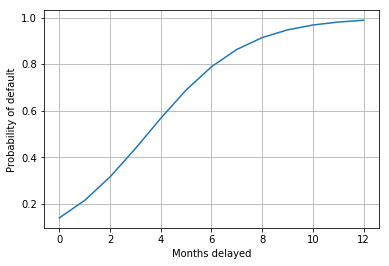

In [10]:
fig, ax = plt.subplots()
ax.plot(months, pred_probs)
ax.set_xlabel('Months delayed')
ax.set_ylabel('Probability of default')
ax.grid()

### A complete Logistic Regression model

In [11]:
log_reg = LogisticRegression(C=1e6)
log_reg.fit(X_train, y_train)

LogisticRegression(C=1000000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [12]:
prob_log_reg = log_reg.predict_proba(X_train)
prob_log_reg[:10]

array([[0.80546441, 0.19453559],
       [0.89230804, 0.10769196],
       [0.80288351, 0.19711649],
       [0.85899725, 0.14100275],
       [0.19901693, 0.80098307],
       [0.82373747, 0.17626253],
       [0.70903546, 0.29096454],
       [0.79648631, 0.20351369],
       [0.81846397, 0.18153603],
       [0.73849053, 0.26150947]])

In [13]:
y_pred_log_reg = log_reg.predict(X_train)
y_pred_log_reg[:10]

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])

In [14]:
np.all(y_pred_log_reg == (prob_log_reg[:,1] > 0.5))

True

In [15]:
pd.Series(data=log_reg.coef_[0], index=X_train.columns).sort_values(ascending=False).round(2)

months_delayed    0.75
bill_amt2         0.22
bill_amt3         0.18
married           0.17
grad_school       0.13
male              0.11
university        0.11
age               0.06
pay_amt3         -0.00
pay_amt4         -0.02
bill_amt5        -0.03
pay_amt5         -0.03
pay_amt6         -0.04
bill_amt4        -0.06
bill_amt6        -0.06
bill_amt1        -0.16
limit_bal        -0.18
pay_amt1         -0.23
pay_amt2         -0.31
dtype: float64

In [16]:
from sklearn.metrics import accuracy_score
accuracy_log_reg = accuracy_score(y_true=y_train, y_pred=y_pred_log_reg)
accuracy_log_reg

0.80372

## Classification Trees

In [17]:
from sklearn.tree import DecisionTreeClassifier
class_tree = DecisionTreeClassifier(max_depth=3)
class_tree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [18]:
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
from IPython.display import Image  
import pydotplus

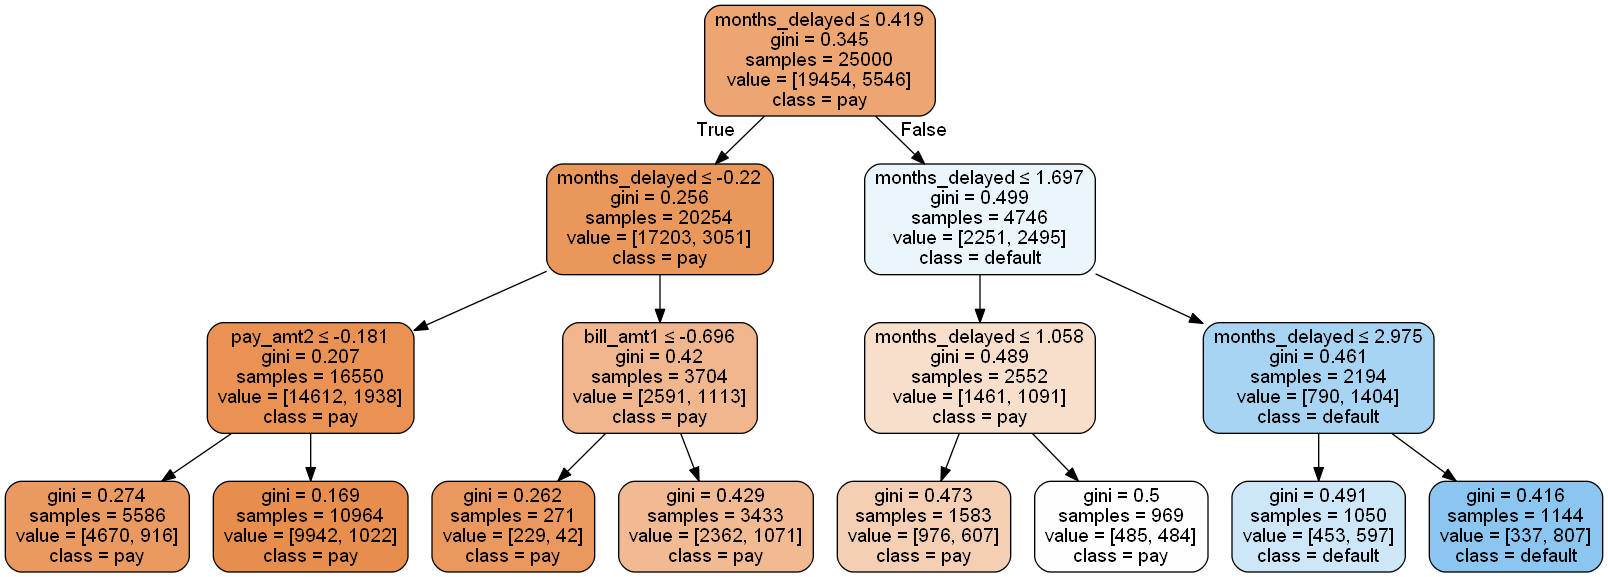

In [19]:
dot_data = StringIO()
export_graphviz(decision_tree=class_tree,
                out_file=dot_data,
                filled=True,
                rounded=True,
                feature_names = X_train.columns,
                class_names = ['pay','default'],
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

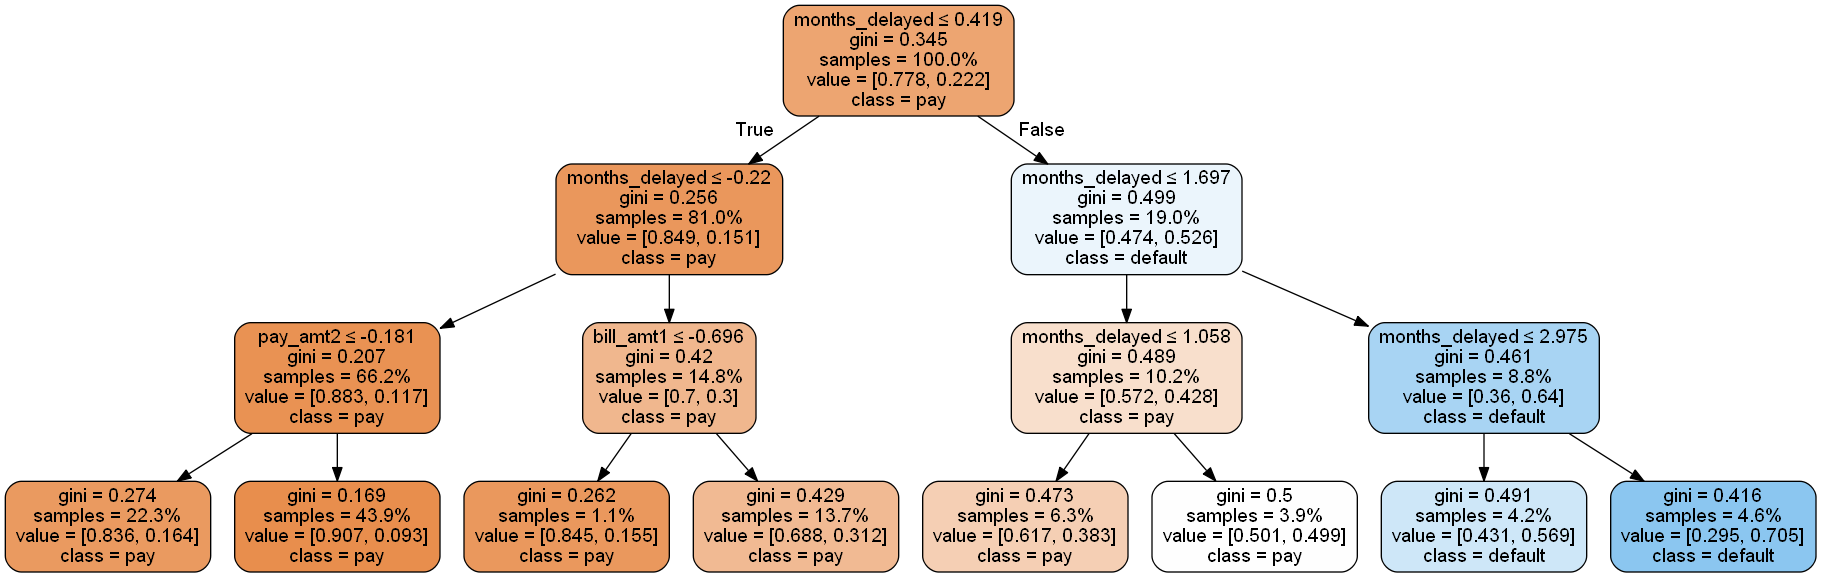

In [20]:
dot_data = StringIO()
export_graphviz(decision_tree=class_tree,
                out_file=dot_data,
                filled=True,
                rounded=True,
                proportion=True,
                feature_names = X_train.columns,
                class_names = ['pay','default'],
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### How trees work

In [21]:
from sklearn.datasets import make_blobs

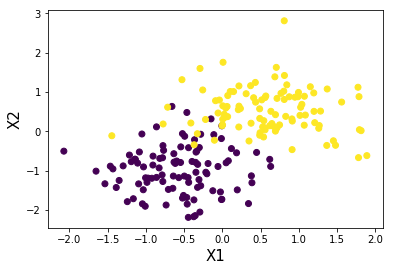

In [22]:
A, b = make_blobs(n_samples=200, n_features=2, cluster_std=0.6,
                  centers=[[-0.5,-1],[0.5,0.5]], shuffle=False, random_state=42)
plt.scatter(A[:, 0], A[:, 1], c=b)
plt.xlabel('X1', size=15)
plt.ylabel('X2', size=15);

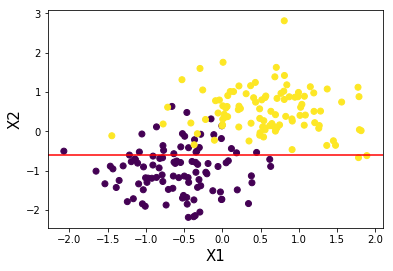

In [23]:
plt.scatter(A[:, 0], A[:, 1], c=b)
plt.axhline(-0.6, c='red')
plt.xlabel('X1', size=15)
plt.ylabel('X2', size=15);

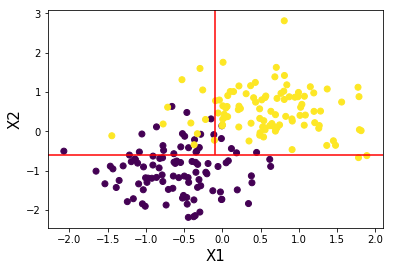

In [24]:
plt.scatter(A[:, 0], A[:, 1], c=b)
plt.axhline(-0.6, c='red')
plt.axvline(x=-0.1, ymin=0.34, c='red')
plt.xlabel('X1', size=15)
plt.ylabel('X2', size=15);

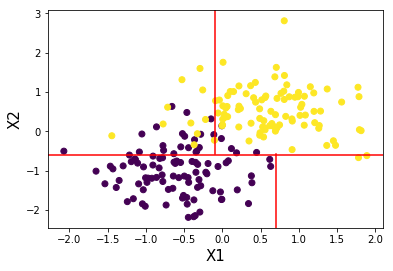

In [25]:
plt.scatter(A[:, 0], A[:, 1], c=b)
plt.axhline(-0.6, c='red')
plt.axvline(x=-0.1, ymin=0.34, c='red')
plt.axvline(x=0.7, ymax=0.34, c='red')
plt.xlabel('X1', size=15)
plt.ylabel('X2', size=15);

### Training a larger classification tree

In [26]:
class_tree = DecisionTreeClassifier(max_depth=6, min_samples_split=50)
class_tree.fit(X_train, y_train)
y_pred_class_tree = class_tree.predict(X_train)

In [27]:
accuracy_class_tree = accuracy_score(y_true=y_train, y_pred=y_pred_class_tree)
accuracy_class_tree

0.80824

In [28]:
pd.Series(data=class_tree.feature_importances_, index=X_train.columns).sort_values(ascending=False).round(3)

months_delayed    0.828
pay_amt2          0.042
bill_amt1         0.022
limit_bal         0.020
pay_amt1          0.018
bill_amt2         0.015
bill_amt6         0.011
pay_amt4          0.010
bill_amt5         0.007
pay_amt3          0.007
age               0.006
pay_amt6          0.004
pay_amt5          0.003
bill_amt3         0.003
grad_school       0.002
bill_amt4         0.002
male              0.000
married           0.000
university        0.000
dtype: float64

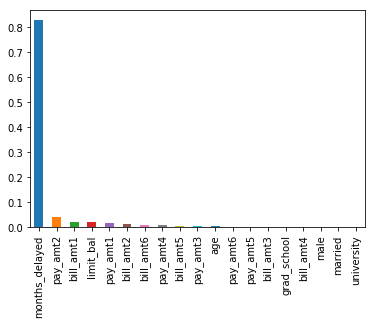

In [29]:
pd.Series(data=class_tree.feature_importances_, index=X_train.columns).sort_values(ascending=False).plot(kind='bar');

## Random Forests

In [30]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=99,
                            max_features=6,
                            max_depth=6,
                            min_samples_split=100,
                            random_state=85)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_train)

In [31]:
accuracy_rf = accuracy_score(y_true=y_train, y_pred=y_pred_rf)
accuracy_rf

0.80744

In [32]:
pd.Series(data=rf.feature_importances_, index=X_train.columns).sort_values(ascending=False).round(3)

months_delayed    0.631
pay_amt1          0.069
limit_bal         0.058
pay_amt2          0.042
pay_amt3          0.034
bill_amt2         0.027
bill_amt1         0.022
bill_amt3         0.020
pay_amt4          0.019
bill_amt4         0.019
bill_amt5         0.017
bill_amt6         0.014
pay_amt6          0.014
pay_amt5          0.007
age               0.005
married           0.000
grad_school       0.000
male              0.000
university        0.000
dtype: float64

## Training vs Testing Error

In [34]:
y_pred_null = np.zeros_like(y_test)
accuracy_score(y_true=y_test, y_pred=y_pred_null)

0.782

In [33]:
## Remember to also standarize the numerical features in the testing set
X_test.loc[:, numerical_features] = scaler.transform(X_test[numerical_features])

C:\Users\direc\Anaconda3\envs\mybook\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [35]:
## Calculating accuracy
accuracies = pd.DataFrame(columns=['train', 'test'], index=['LogisticReg','ClassTree','RF'])
model_dict = {'LogisticReg': log_reg, 'ClassTree': class_tree, 'RF': rf}
for name, model in model_dict.items():
    accuracies.loc[name, 'train'] = accuracy_score(y_true=y_train, y_pred=model.predict(X_train))
    accuracies.loc[name, 'test'] = accuracy_score(y_true=y_test, y_pred=model.predict(X_test))

accuracies

,train,test
LogisticReg,0.80372,0.8058
ClassTree,0.80824,0.8074
RF,0.80744,0.8054


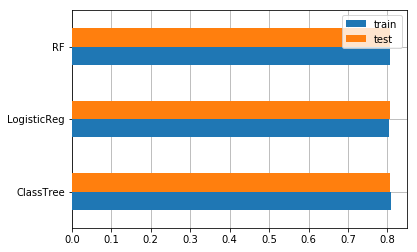

In [36]:
fig, ax = plt.subplots()
accuracies.sort_values(by='test', ascending=False).plot(kind='barh', ax=ax, zorder=3)
ax.grid(zorder=0)

## Multiclass classification

In [37]:
# Loading the iris dataset
from sklearn.datasets import load_iris
iris = load_iris()
# Training the logistic regression model
iris_log_reg = LogisticRegression(C=1e5)
iris_log_reg.fit(iris.data, iris.target)
iris_probs = iris_log_reg.predict_proba(iris.data)
iris_pred = iris_log_reg.predict(iris.data)

In [38]:
iris_pred_df = pd.DataFrame(iris_probs, columns=iris.target_names).round(4)
iris_pred_df['predicted_class'] = iris.target_names[iris_pred]
iris_pred_df.sample(12)

,setosa,versicolor,virginica,predicted_class
45,0.8144,0.1856,0.0000,setosa
21,0.9682,0.0318,0.0000,setosa
108,0.0000,0.4426,0.5574,virginica
51,0.0000,0.9997,0.0003,versicolor
48,0.9501,0.0499,0.0000,setosa
74,0.0000,1.0000,0.0000,versicolor
121,0.0000,0.2223,0.7777,virginica
33,0.9887,0.0113,0.0000,setosa
38,0.7855,0.2145,0.0000,setosa
105,0.0000,0.3289,0.6711,virginica
